In [1]:
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.tree import Tree
from sklearn.decomposition import TruncatedSVD
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from nltk.stem.porter import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


stemmer = PorterStemmer()

# Functions

In [2]:
def remove_triples(word):
    s = word+' '
    j = 1
    refined=''
    for i in range(1,len(s)):
        if s[i]==s[i-1]:
            j +=1

        elif j < 3:
            refined += s[i-1]*j
            j = 1
        else:
            refined += s[i-1]
    return refined

def preprocess_twit(text):
    
    #getting label and twit
    twit_cat = str(re.findall('positive[\W\w\d\D]+|negative[\W\w\d\D]+|neutral[\W\w\d\D]+',text)[0])
    cat = re.findall('\Anegative|positive|neutral',twit_cat)[0] #getting label
    twit = re.sub(cat, '',twit_cat).strip() #getting twit

    twit = re.sub('((pic.twitter.[^\s]+)|(www\.[^\s]+)|(https?://[^\s]+))','', twit) #remove URLS
    twit = re.sub('@[^\s]+','', twit)  #remove users
    
    twit = re.sub('[:;^8=]{1}-?[)PD8o]+', ' positive_smile', twit) #smiles processing
    twit = re.sub('[:;^8=]{1}-?[(/|]+', ' negative_smile', twit)
    
    
    twit = re.sub("\s{2,}",' ',twit)
    
    twit = re.sub("n't"," not", twit).strip() #processsing "not"
    twit = re.sub("not ","not_", twit).strip() #processsing "not"
    

    twit = re.sub("\s!+|!+", ' !!', twit).lower() #exlamation mark 

    twit = re.sub("[^a-zA-Zа-яА-Я_!]+", ' ', twit).lower() #punctuation marks removal
    
    twit = ' '.join(list(filter(lambda x: len(x)!=1,twit.split(' ')))) #one-symbol words removal

    twit = re.sub(r'\b(st|nd|rd|th)(\b\s|\Z){1}', '', twit) #2-symbol words removal
    
    twit = ' '.join(list(map(remove_triples, twit.split(' ')))) #remove characters repeats
    
    twit = ' '.join(list(filter(lambda x: x not in stopwords.words('english'), twit.split(' ')))).strip() #removing stopwords
    twit = ' '.join([stemmer.stem(i) for i in twit.split(' ')])
    
    return cat,twit

def preprocess(twit):
    
    twit = re.sub('((pic.twitter.[^\s]+)|(www\.[^\s]+)|(https?://[^\s]+))','', twit) #remove URLS
    twit = re.sub('@[^\s]+','', twit)  #remove users
    
    twit = re.sub('[:;^8=]{1}-?[)PD8o]+', ' positive_smile', twit) #smiles processing
    twit = re.sub('[:;^8=]{1}-?[(/|]+', ' negative_smile', twit)
    
    
    twit = re.sub("\s{2,}",' ',twit)
    
    twit = re.sub("n't"," not", twit).strip() #processsing "not"
    twit = re.sub("not ","not_", twit).strip() #processsing "not"
    

    twit = re.sub("!+", ' !!', twit).lower() #exlamation mark 

    twit = re.sub("[^a-zA-Zа-яА-Я_!]+", ' ', twit).lower() #punctuation marks removal

    #twit = ' '.join(list(filter(lambda x: len(x)!=1,twit.split(' ')))) #one-symbol words removal

    twit = re.sub(r'\b(st|nd|rd|th)(\b\s|\Z){1}', '', twit) #2-symbol words removal
    
    
    twit = ' '.join(list(map(remove_triples, twit.split(' ')))) #remove characters repeats
    
    twit = ' '.join(list(filter(lambda x: x not in stopwords.words('english'), twit.split(' ')))).strip() #removing stopwords
    twit = ' '.join([stemmer.stem(i) for i in twit.split(' ')])
    
    return twit

def remove_ner(text):
    chunked = ne_chunk(pos_tag(re.split('\s+',text.strip())))
    continuous_chunk = []
    current_chunk = []
    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue
    
    for i in continuous_chunk:
        try:
            text = re.sub(r"{}('s)?".format(i),'', text)
        except:
            continue

    return text

def refine_twit(data):
    data = preprocess_twit(data)
    #data = preprocess_twit(remove_ner(data))
    return data
                
sent2 = "263527525819502592	230687653	negative	Cupid did so ! much work da 1st time that he don't wanna be my friend no more!"
print(refine_twit(sent2))

('negative', 'cupid !! much work da time not_wanna friend no more !!')


# Adding Negative Samples

In [97]:
neg_texts, pos_texts = [],[]
with open("corpora/2016-twiter-polarity-train.tsv.res",encoding='UTF-8') as f:
    f = list(f)
    for i in f:
        try:
            
            label,text = refine_twit(i)
            if label == 'negative':
                neg_texts.append(text)
            elif label == 'positive':
                pos_texts.append(text)
        except:
            print('error in line {}'.format(f.index(i)))
            print(i)
            continue
            
with open("corpora/2014-twiter-polarity-train.tsv.res",encoding='UTF-8') as f:
    f = list(f)
    for i in f:
        try:
            label,text = refine_twit(i)
            if label == 'negative':
                neg_texts.append(text)
            elif label == "positive":
                pos_texts.append(text)
        except:
            continue

print(len(neg_texts))
print(len(pos_texts))

1356
4414


# Train Dataset

In [65]:
train_data = []
train_labels = []
with open("2013-twiter-polarity-train.tsv.res",encoding='UTF-8') as f:
    f = list(f)
    for i in f:
        try:
            label,text = refine_twit(i)
            train_data.append(text)
            train_labels.append(label)
        except:
            print('error in line {}'.format(f.index(i)))
            print(i)
            continue
            
train_data += neg_texts
train_labels += ['negative']*len(neg_texts) 


### CSV manipulations

### Save

In [66]:
df = pd.DataFrame({"Twits":train_data,"Labels":train_labels})
df.to_csv('train_dataset_!', index = False)

### Open

In [3]:
#open train
train_df = pd.read_csv('train_dataset_!')

train_data = list(train_df.Twits)
train_labels = list(train_df.Labels)
#train_df[train_df.Labels == 'neu']
#train_df[train_df.isnull().any(axis=1)]
#train_df.dropna(inplace=True)

# Test Dataset

In [68]:
test_data = []
test_labels = []
with open("2013-twiter-polarity-dev.tsv.res",encoding='UTF-8') as f:
    f = list(f)
    for i in f:
        try:
            label,text = refine_twit(i)
            test_data.append(text)
            test_labels.append(label)
        except:
            print('error in line {}'.format(f.index(i)))
            continue


### CSV manipulations

### Save

In [69]:
#save to csv
test_df = pd.DataFrame({"Twits":test_data,"Labels":test_labels})
test_df.to_csv('test_dataset_!', index = False)

### Open

In [4]:
### Open#open test
test_df = pd.read_csv('test_dataset_!')
test_data = list(test_df.Twits)
test_labels = list(test_df.Labels)

# Statistics

### Decreasing neutral samples

In [5]:
train_df.drop(train_df[train_df.Labels == 'neutral'].iloc[:1000].index,inplace=True)
len(train_df)

6771

In [6]:
all_labels = list(train_df.Labels.values.astype(str)) + list(test_df.Labels.values.astype(str))
all_features = list(train_df.Twits.values.astype(str)) + list(test_df.Twits.values.astype(str))

print("Предложений в train data:",train_df.shape[0])
print("\nTrain Data\nNegative -", train_df[train_df.Labels == 'negative'].shape[0])
print("Neutral -", train_df[train_df.Labels == 'neutral'].shape[0])
print("Positive -", train_df[train_df.Labels == 'positive'].shape[0])

print("\nПредложений в test data:",test_df.shape[0])
print("\nTest Data\nNegative -", test_df[test_df.Labels == 'negative'].shape[0])
print("Neutral -", test_df[test_df.Labels == 'neutral'].shape[0])
print("Positive -", test_df[test_df.Labels == 'positive'].shape[0])

print("\nВсего предложений:", len(all_features))
print("Negative -", all_labels.count('neutral'))
print("Neutral -", all_labels.count('negative'))
print("Positive -", all_labels.count('positive'))

Предложений в train data: 6771

Train Data
Negative - 2262
Neutral - 2170
Positive - 2339

Предложений в test data: 1009

Test Data
Negative - 187
Neutral - 453
Positive - 369

Всего предложений: 7780
Negative - 2623
Neutral - 2449
Positive - 2708


#  WordCloud

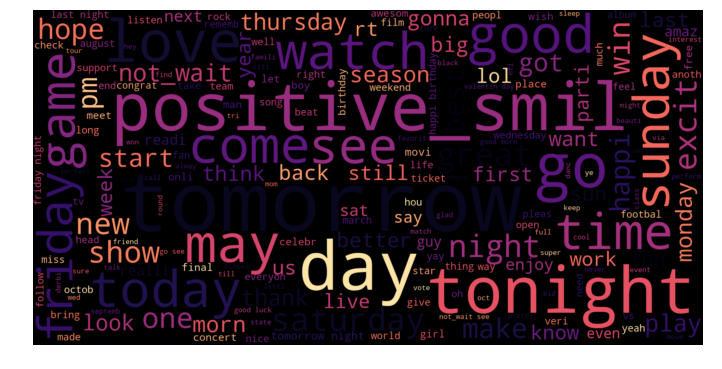

In [73]:
from wordcloud import WordCloud

pos_tweets = train_df[train_df.Labels == 'positive'].Twits
pos_string = []
for t in pos_tweets:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

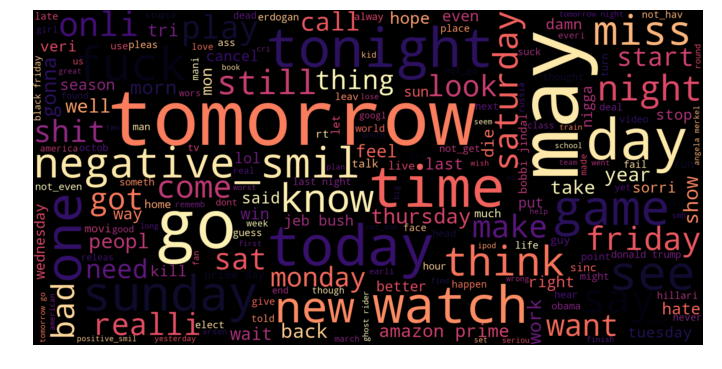

In [74]:
neg_tweets = train_df[train_df.Labels == 'negative'].Twits
neg_string = []
for t in neg_tweets:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(neg_string) 
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

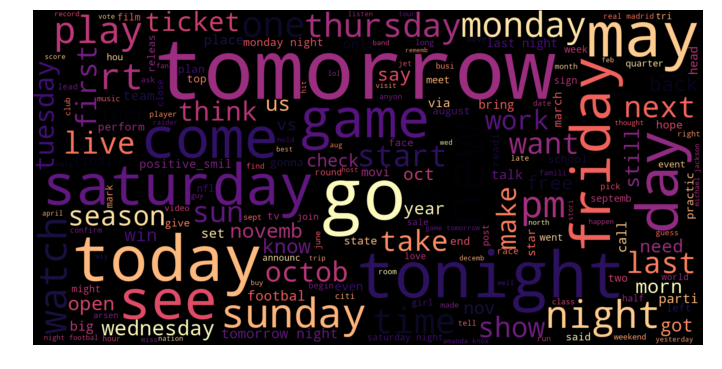

In [75]:
neu_tweets = train_df[train_df.Labels == 'neutral'].Twits
neu_string = []
for t in neu_tweets:
    neu_string.append(t)
neu_string = pd.Series(neu_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(neu_string) 
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# CountVectorizer

In [7]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=2)
features = vectorizer.fit_transform(all_features).toarray()
print("Матрица предложения/признаки:", features.shape)

X_train, X_test, y_train, y_test  = train_test_split(features, all_labels, train_size=0.80, test_size = 0.2, random_state=1234)
#X_train, X_test, y_train, y_test = features[:len(train_data)], features[len(train_data):], all_labels[:len(train_data)], all_labels[len(train_data):]
#print(X_test[0])

Матрица предложения/признаки: (7780, 30330)


# TfIdfVectorizer

In [134]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),min_df=2, use_idf=True, max_features=35000, max_df = 0.5)
features = vectorizer.fit_transform(all_features).toarray()
print("Матрица предложения/признаки:", features.shape)

svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
features_lsa = svd.fit_transform(features)
explained_variance = svd.explained_variance_ratio_.sum()

X_train, X_test, y_train, y_test  = train_test_split(features, all_labels, train_size=0.80, test_size = 0.2, random_state=1234)
X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa  = train_test_split(features_lsa, all_labels, train_size=0.80, test_size = 0.2, random_state=1234)
print("Матрица предложения/признаки LSA:", features_lsa.shape)

Матрица предложения/признаки: (7780, 30330)
Матрица предложения/признаки LSA: (7780, 300)


### Logistic Regression

In [87]:
def best_model(models = {}):
    for i,k in models.items():
        print(i+'\n')
        
        grid = GridSearchCV(k, parameters, cv=5)
    
        grid.fit(X=X_train, y=y_train)
        print(grid.best_estimator_)

        
for i in [0.1, 0.2, 0.3, 0.5, 1.0, 2.0 ,4.0, 5.0]:
    
    log_model = LogisticRegression(C=i,solver = 'saga', multi_class='multinomial',max_iter=300, n_jobs=-1)
    log_model.fit(X_train,y_train)


    print(i,log_model.score(X_test,y_test))

0.1 0.7506426735218509
0.2 0.7480719794344473
0.3 0.7525706940874036
0.5 0.7551413881748072
1.0 0.7532133676092545
2.0 0.7506426735218509


/home/silenos/.local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


4.0 0.7467866323907455


/home/silenos/.local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


5.0 0.7429305912596401


In [88]:
from sklearn import svm
for i in [0.1, 0.2, 0.3, 0.5, 1.0, 2.0 ,4.0, 5.0]:
    
    svc_model = svm.LinearSVC(masvc_modeler=5000, C = i)
    svc_model.fit(X_train,y_train)
    
    print(i,svc_model.score(X_test,y_test))

0.1 0.7467866323907455
0.2 0.743573264781491
0.3 0.7352185089974294
0.5 0.7326478149100257
1.0 0.730719794344473
2.0 0.7281491002570694
4.0 0.7262210796915167


/home/silenos/.local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


5.0 0.724293059125964


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# parameters = {'C':[0.1, 0.2, 0.3, 0.5, 1.0, 2.0 ,4.0, 5.0]}
# log_model = LogisticRegression(solver = 'sag', multi_class='multinomial',max_iter=300, n_jobs=-1)
# svc_model = svm.LinearSVC(max_iter=200)
            
# best_model(models = {'Logistic Regression':log_model, "Support Vector Machine":svc_model})

# print(round(log_model.score(X_test, y_test),4))

# CountVectorizer 0.7 74,5 max_features = 10000 min_df = 2 ngram = 1-3, + negative_texts , without ner
# TfIdfVectorizer 5 75,1 % max_features = all min_df = 2 ngram = 1-3, + negative_texts , - neutral , without ner

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# svc_model = svm.LinearSVC(max_iter=5000,C = 1.0)
# svc_model.fit(features_lsa, all_labels)
# print('LSA:', cross_val_score(svc_model,features_lsa, all_labels,cv=5).mean())

print("Logistic Regression")

log_model = LogisticRegression(C=0.5, solver = "saga", multi_class='multinomial',max_iter=100)
log_model.fit(features, all_labels)
print('Non-LSA:', cross_val_score(log_model,features,all_labels,cv=10).mean())


# svc_model = svm.LinearSVC(max_iter=5000, C = 0.1)

# print("Support Vector Machine")

# svc_model.fit(X=features, y=all_labels)
# print('Non-LSA:', cross_val_score(svc_model,features, all_labels,cv=5).mean())

# log_model = LogisticRegression(solver = 'sag', multi_class='multinomial',max_iter=200, C=4.0, n_jobs = -1)

# log_model.fit(features_lsa, all_labels)
# print('LSA:', cross_val_score(log_model,features_lsa,all_labels,cv=5).mean())

Logistic Regression


MemoryError: 

Support Vector Machine
Non-LSA: 0.6997539669821885


### SVM

In [178]:
from sklearn import svm
from sklearn.model_selection import cross_val_score


clf = svm.LinearSVC(max_iter=5000, C=0.2)
clf.fit(X_train, y_train)

#print(clf.score(X_test, y_test))
score = cross_val_score(clf,features,all_labels,cv=5)
print(score.mean())
# score = cross_val_score(log_model,features,all_labels,cv=5)
# print(score.mean())

0.6795659883599218


In [176]:
log_model = LogisticRegression(C=2.0, solver = 'sag', multi_class='multinomial', max_iter=200, n_jobs = -1)
log_model.fit(X_train, y_train)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [177]:
from sklearn.metrics import classification_report
print(classification_report(y_test, log_model.predict(X_test), digits=4))

             precision    recall  f1-score   support

   negative     0.8289    0.8289    0.8289       491
    neutral     0.6882    0.7245    0.7059       530
   positive     0.7594    0.7196    0.7390       535

avg / total     0.7571    0.7558    0.7561      1556



In [174]:
from sklearn.metrics import classification_report
print(classification_report(y_test, log_model.predict(X_test),digits=4)) #with negative words

             precision    recall  f1-score   support

   negative     0.9918    0.9837    0.9877       491
    neutral     0.9451    0.9736    0.9591       530
   positive     0.9694    0.9477    0.9584       535

avg / total     0.9682    0.9679    0.9679      1556



In [179]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test),digits=4)) #with negative words
print(len(X_test))

             precision    recall  f1-score   support

   negative     0.8114    0.8411    0.8260       491
    neutral     0.6832    0.7038    0.6933       530
   positive     0.7605    0.7121    0.7355       535

avg / total     0.7502    0.7500    0.7497      1556

1556


In [360]:
df = pd.read_tsv

In [105]:
twit = "Why would you still wear shorts when it's this cold?! I love how Britain see's a bit of sun and they're like 'OOOH LET'S STRIP!"
twit = preprocess(twit)
print(twit)
twit = vectorizer.transform([twit])

print('Logistic Regression')
print('Negative - {}\nNeutral - {}\nPositive - {}'.format(round(log_model.predict_proba(twit)[0][0],3),
                                                          round(log_model.predict_proba(twit)[0][1],3),
                                                          round(log_model.predict_proba(twit)[0][2],3)))
print(log_model.predict(twit))
print('\nSVM')
print(clf.predict(twit))

would still wear short cold ! love britain see bit sun like oh let strip!


NameError: name 'vectorizer' is not defined